In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
# Copyright (c) 2017-present, Facebook, Inc.
# All rights reserved.
#
# This source code is licensed under the license found in the
# LICENSE file in the root directory of this source tree.
#

from __future__ import absolute_import, division, unicode_literals

import sys
import numpy as np
import logging
import sklearn
from datasets import load_dataset, load_from_disk
from tqdm import tqdm
import os
import json
import pytorch_lightning as pl
import torch
from torch import utils

import matplotlib.pyplot as plt


sys.path.insert(0, 'nli/')
from setup import load_model, prep_sent, find_checkpoint
from data import NLIDataModule, DataSetPadding

In [3]:
class Args:
    def __init__(self, model_type = 'avg_word_emb', ckpt_path = None, version = 'version_0', path_to_vocab = 'store/vocab.pkl', num_workers = 3):
        self.model_type = model_type
        self.ckpt_path = model_type if ckpt_path is None else ckpt_path
        self.version = version
        self.path_to_vocab = path_to_vocab
        self.num_workers = num_workers

args = Args('avg_word_emb')

In [4]:
with open('data/examples_snli.json', 'r') as f:
    predict_data = json.load(f)
predict_data

{'premise': ['Two men sitting in the sun',
  'A man is walking the dog',
  'We are enjoying this a lot',
  'Everything else besides reading is boring'],
 'hypothesis': ['Nobody is sitting in the shade',
  'No cat is outside',
  'You and I are having fun together',
  'I do not like to consume books'],
 'label': [1, 1, 0, 2]}

In [5]:
# load preds
_, version_path = find_checkpoint(args.ckpt_path, args.version)
preds = torch.load(os.path.join(version_path, 'preds.pt'))
preds

tensor([[0.1119, 0.2218, 0.6662],
        [0.0160, 0.0084, 0.9756],
        [0.3670, 0.5897, 0.0433],
        [0.1018, 0.5245, 0.3736]])

In [6]:
models ={'avg_word_emb': 'AvgWordEmb', 'uni_lstm': 'UniLSTM'}#, 'bi_lstm': 'BiLSTM', 'max_pool_lstm': 'MaxPoolLSTM'}

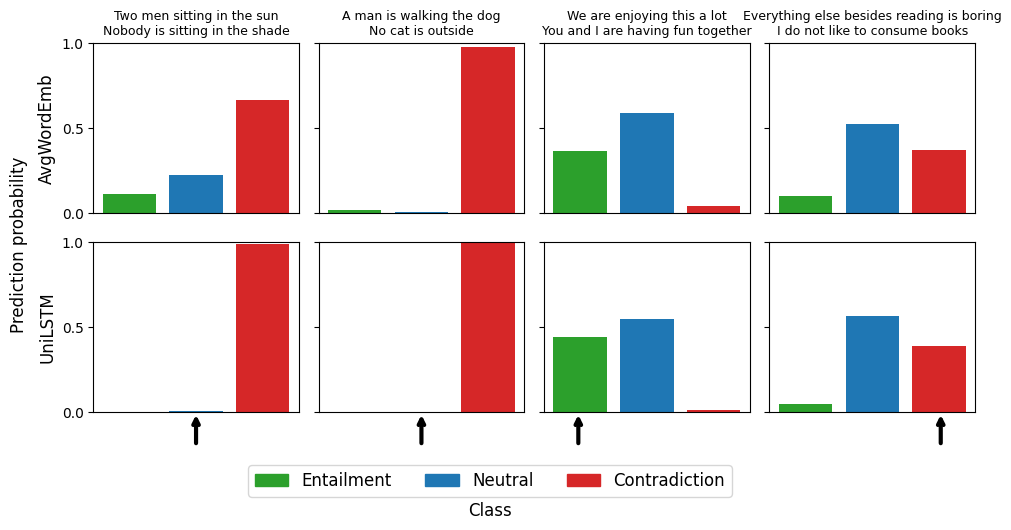

In [45]:
size = 2.5
colors = {'Entailment' : 'tab:green', 'Neutral' : 'tab:blue', 'Contradiction' : 'tab:red'}
label_dict = {0 : 1/6, 1 : 0.5, 2 : 5/6}

n_pred = len(predict_data['label'])
n_models = len(models)
labels = list(colors.keys())

fig, axs = plt.subplots(n_models, n_pred, figsize=(n_pred*size, n_models*size), sharey=True, sharex=True)

x = np.arange(3)
for row_i, model in enumerate(models.keys()):
    _, version_path = find_checkpoint(model, args.version)
    preds =  torch.load(os.path.join(version_path, 'preds.pt'))
    for col_i, (pred, ax) in enumerate(zip(preds, axs[row_i])):
        ax.bar(x, pred, color = list(colors.values()))
        ax.set_xticks([])
        ax.set_yticks([0, 0.5, 1])
        ax.set_ylim(0, 1)
        label = label_dict[predict_data['label'][col_i]]

        if col_i == 0:
            ax.set_ylabel(models[model], size = 12)
        if row_i == 0:
            ax.set_title(f"{predict_data['premise'][col_i]}\n{predict_data['hypothesis'][col_i]}", size = 9)
        if row_i == n_models-1:
            ax.annotate('', xy=(label, -0.), xycoords='axes fraction', xytext=(label, -0.2), 
                    arrowprops=dict(arrowstyle="->", color='black', lw=3))

handles = [plt.Rectangle((0,0),1,1, color=colors[label]) for label in labels]
fig.legend(handles, labels, loc='lower center', prop={'size': 12}, ncol=3, bbox_to_anchor=(0.5, -0.02))

fig.supylabel('Prediction probability')
fig.supxlabel('Class', y = -0.05)

plt.tight_layout()

plt.show()
    